In [2]:
import PolynomialRoots.roots
using Distributions
using Plots
using PGFPlotsX
using LaTeXStrings
using Colors
using JLD
using Parameters
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [130]:
using Random
Random.seed!(42)

MersenneTwister(42)

In [137]:
@unpack speech_data, noise_data, rγ, rmθ, rvθ, rmx, rvx, rτ, rmη, rvη, rmz, rvz = JLD.load("jlds/coupled_ar.jld");

Dict{String, Any} with 12 entries:
  "rvz"         => [0.209553 0.186014 … 0.197358 0.234594; 0.174367 0.17429 … 0…
  "rmz"         => [0.527773 -0.157931 … -0.930114 0.139958; 1.48064 0.590398 ……
  "rvθ"         => Any[[0.00966394 0.00712845 0.00758662 0.000155139; 0.0071284…
  "rvη"         => Any[[0.00661246], [0.00916538 0.0111524 0.00397711; 0.011152…
  "noise_data"  => [([-0.210409], [[0.222001], [-0.181659], [0.413966], [0.1857…
  "rmη"         => Any[[0.577027], [-1.34654, -0.806668, -0.314372], [-1.58938,…
  "rγ"          => [(51.0, 15.3114), (51.0, 10.1961), (51.0, 9.18817), (51.0, 9…
  "rmx"         => [-0.233572 -0.246246 … -0.463908 -0.375859; 1.50592 -1.84256…
  "rτ"          => [(51.0, 19.7225), (51.0, 30.5068), (51.0, 10.5986), (51.0, 1…
  "rvx"         => [0.209553 0.186013 … 0.197357 0.234594; 0.174374 0.174182 … …
  "speech_data" => [([0.296762, -0.51642, 0.495933, -0.347842], [[0.0721997, -0…
  "rmθ"         => Any[[-0.760145, -0.837214, -0.0626256, -0.0349474], [1.

In [1]:
function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    else
        coefs = randn(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [131]:
n_datasets = 100
n_samples = 100
AR_z = 4:8
AR_x = 1:4
noise_var = [1.0, 0.3, 0.1]
SNR_s = rand(noise_var, n_datasets)
speech_data, noise_data = [generateAR(100, rand(AR_z)) for _ in 1:n_datasets], [generateAR(100, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

### Coupled AR inference

In [132]:
using AIDA
using ReactiveMP
import ProgressMeter

vmp_its = 100

rmx = zeros(n_datasets, n_samples)
rvx = zeros(n_datasets, n_samples)
rmθ, rvθ = [], []
rγ = fill(tuple(.0, .0), n_datasets)

rmz = zeros(n_datasets, n_samples)
rvz = zeros(n_datasets, n_samples)
rmη, rvη  = [], []
rτ = fill(tuple(.0, .0), n_datasets)

fe  = zeros(n_datasets, vmp_its)

ProgressMeter.@showprogress for i in 1:n_datasets
    
    output = first.(speech_data[i][2]) + first.(noise_data[i][2])
    ar_speech, ar_env = length(speech_data[i][1]), length(noise_data[i][1])
    
    priors_mη, priors_vη, priors_τ = prior_to_priors(zeros(ar_env), diageye(ar_env), (1.0, SNR_s[i]), n_samples, ar_env)
    
    prior_η                           = (priors_mη[i, :], priors_vη[i, :, :])
    prior_τ                           = priors_τ[i]
    γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference(output, prior_η, prior_τ, ar_speech, ar_env, vmp_its)
    mz, vz                            = mean.(zs), cov.(zs)
    mθ, vθ                            = mean(θ), cov(θ)
    rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)
    
    push!(rmθ, mθ)
    push!(rvθ, vθ)
    
    rγ[i]                             = shape(γ), rate(γ)
    
    mx, vx                            = mean.(xs), cov.(xs)
    mη, vη                            = mean(η), cov(η)
    rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
    push!(rmη, mη)
    push!(rvη, vη)
    rτ[i]                             = shape(τ), rate(τ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


In [133]:
JLD.save("jlds/coupled_ar.jld", "speech_data", speech_data, "noise_data", noise_data, 
                                "rγ", rγ, "rmθ", rmθ, "rvθ", rvθ, "rmx", rmx, "rvx", rvx, 
                                "rτ", rτ, "rmη", rmη, "rvη", rvη, "rmz", rmz, "rvz", rvz)

In [139]:
# 13 11
index = 13
ar_1 = first.(speech_data[index][2])
ar_2 = first.(noise_data[index][2])
output = ar_1 + ar_2
axis1 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {only_marks,color="black",opacity=0.8, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:n_samples), y = output
        ),
    ), LegendEntry("observations"),
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1])))"),
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    )
pgfsave("tmp/coupled_AR_signal.pdf", axis1)
pgfsave("tikz/coupled_AR_signal.tikz", axis1)

In [140]:
axis2 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="orange"}, Coordinates(collect(1:n_samples), ar_1)), LegendEntry("AR($(length(speech_data[index][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmz[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmz[index, :] .+  sqrt.(rvz[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmz[index, :] .-  sqrt.(rvz[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
    )
pgfsave("tmp/coupled_AR_1_inference.pdf", axis2)
pgfsave("tikz/coupled_AR_1_inference.tikz", axis2)

In [141]:
axis3 = @pgf Axis({xlabel=L"t",
           ylabel="value",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
           ymax = 7,
           ymin = -7,
           title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_samples), ar_2)), LegendEntry("AR($(length(noise_data[index][1])))"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_samples), rmx[index, :])),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_samples), rmx[index, :] .+  sqrt.(rvx[index, :]))),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_samples), rmx[index, :] .-  sqrt.(rvx[index, :]))),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
    )
pgfsave("tmp/coupled_AR_2_inference.pdf", axis3)
pgfsave("tikz/coupled_AR_2_inference.tikz", axis3)

In [143]:
# FE
FE = collect(reshape((sum(fe, dims=1)'), (vmp_its, )))
axis4 = @pgf Axis({xlabel="iteration",
                  ylabel="Free energy [nats]",
                  legend_pos = "north east",
                  legend_cell_align="{left}",
                  scale = 1.0,
                  grid = "major",
    },
    Plot({mark = "o", "red"}, Coordinates(collect(1:vmp_its), FE)), LegendEntry("FE"))

pgfsave("tmp/FE.pdf", axis4)
pgfsave("tikz/FE.tikz", axis4)

### FE for context inference

In [117]:
using Random
Random.seed!(0)

AR_params = [
                [[-0.6693908457426764], 1.0], [[0.10842053519608219, 0.7390494065227768], 0.5], 
                [[-0.678351427612566, -0.21078755359601015], 1.0], 
                [[0.7046791518736013, 0.11793145287291551, 0.044013757019289834, -0.3858860748183223], 0.1]
            ]
orders = map(x -> length(x), first.(AR_params))
coefs = map(x -> length(x), last.(AR_params))

n_datasets = 1000
n_samples = 100

ar_data = [generateAR(n_samples, rand(orders),  nvar=rand(coefs)) for i in 1:n_datasets];

In [108]:
function cat_accuracy(y_pred, y_true)
    return sum(y_pred .== y_true) / length(y_true)
end

cat_accuracy (generic function with 1 method)

In [118]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
active_models = []
active_scenes = []
vmp_iter = 50
models = convert(AbstractArray{Any}, map(_ -> lar_inference, orders))
push!(models, inference_gaussian)
priors = map(x -> Dict(:mθ => x[1], :vθ => diageye(length(x[1])), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => x[2], :order => length(x[1])), AR_params)
push!(priors, Dict(:aτ => 1e-4, :bτ => 1.0))
ProgressMeter.@showprogress for j in 1:n_datasets
    push!(active_scenes, length(ar_data[j][1]))
    observations = first.(ar_data[j][2])
    scene = model_selection(observations, 
                            models,
                            priors,
                            vmp_iter=vmp_iter)
    push!(active_models, scene)
end

Progress:  23%|█████████▎                               |  ETA: 0:26:12

In [116]:
cat_accuracy(active_scenes, active_models)

0.82

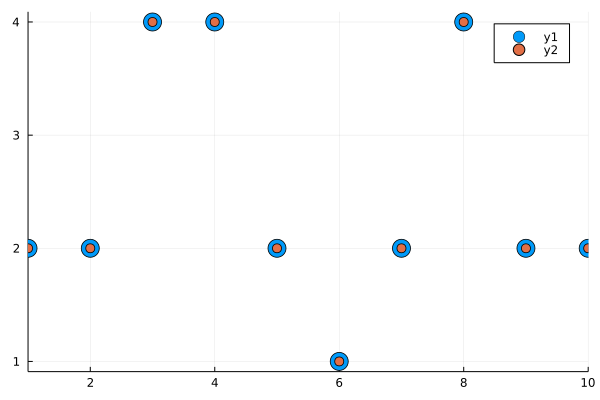

In [115]:
scatter(active_models,markersize=10.0)
scatter!(active_scenes, xlims=(1, 10), markersize=5.0)